In [ ]:
!pip install -U vnstock3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from vnstock3 import Vnstock
import random
from copy import deepcopy

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


    Khi tiếp tục sử dụng Vnstock3, bạn xác nhận rằng bạn đã đọc, hiểu và đồng ý với Chính sách quyền riêng tư và Điều khoản, điều kiện về giấy phép sử dụng Vnstock3.

    Chi tiết:

    - Giấy phép sử dụng phần mềm: https://vnstocks.com/docs/tai-lieu/giay-phep-su-dung
    - Chính sách quyền riêng tư: https://vnstocks.com/docs/tai-lieu/chinh-sach-quyen-rieng-tu
    


In [ ]:
stockVNINDEX = Vnstock().stock(symbol='VNINDEX', source='VCI')
df = stockVNINDEX.quote.history(start='2014-12-01', end='2024-12-01', interval='1D')

2024-12-28 14:22:25 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [ ]:
df['time'] = pd.to_datetime(df['time'])  # Chuyển cột thời gian
df.set_index('time', inplace=True)

In [ ]:
# Tính các đường trung bình động (MA)
df['MA_20'] = df['close'].rolling(window=20).mean()
df['MA_50'] = df['close'].rolling(window=50).mean()

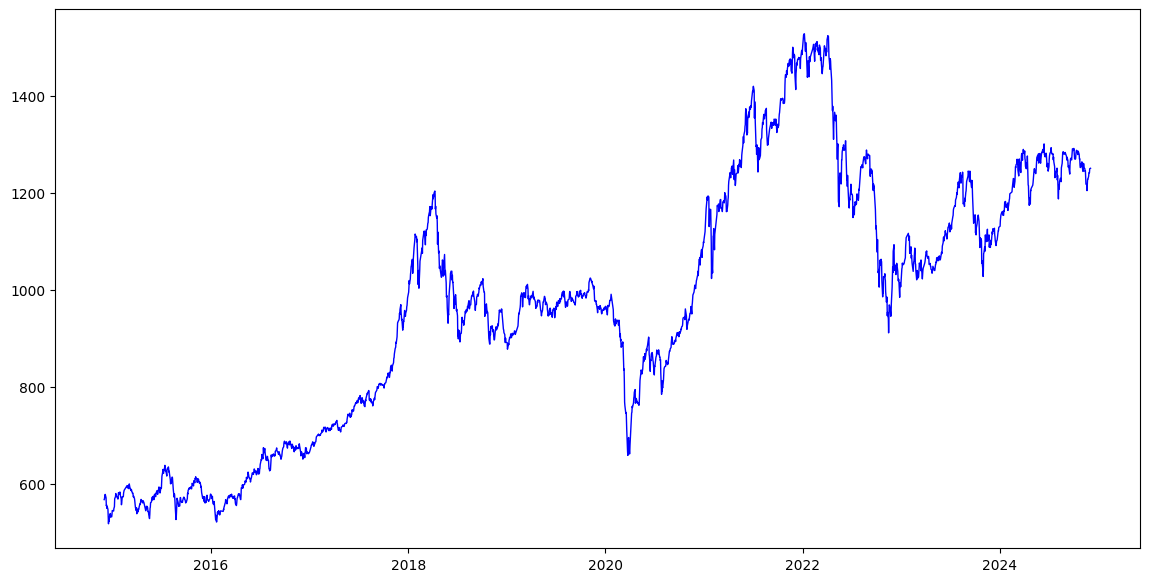

In [ ]:
# Vẽ biểu đồ giá Close với các vùng xu hướng
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], color='blue', label='VNINDEX Close Price', linewidth=1)

In [ ]:
# Xác định xu hướng với ngưỡng Sideways
threshold = 0.01  # 1% giá đóng cửa
df['MA_Diff'] = abs(df['MA_20'] - df['MA_50'])
df['Trend'] = np.where(df['MA_Diff'] / df['close'] <= threshold, 'Sideways',
                       np.where(df['MA_20'] > df['MA_50'], 'Uptrend', 'Downtrend'))

In [ ]:
df.dropna(inplace=True)
df

,open,high,low,close,volume,MA_20,MA_50,MA_Diff,Trend
time,,,,,,,,,
2015-02-11,574.88,581.76,574.88,581.76,77500496,574.2895,561.1714,13.1181,Uptrend
2015-02-12,582.52,584.99,581.86,584.67,82989180,574.6360,561.5046,13.1314,Uptrend
2015-02-13,586.26,589.02,585.60,587.24,73837820,575.2575,561.8608,13.3967,Uptrend
2015-02-24,590.18,596.95,589.74,596.95,62893419,576.5295,562.3022,14.2273,Uptrend
2015-02-25,596.90,601.55,592.66,592.66,99237866,577.5515,562.5878,14.9637,Uptrend
...,...,...,...,...,...,...,...,...,...
2024-11-26,1234.70,1246.83,1234.70,1242.13,575094638,1240.2885,1262.2130,21.9245,Downtrend
2024-11-27,1242.13,1245.34,1239.23,1241.97,428809652,1239.4555,1261.7544,22.2989,Downtrend
2024-11-28,1246.37,1250.46,1240.91,1242.11,477493690,1238.3370,1261.1712,22.8342,Downtrend


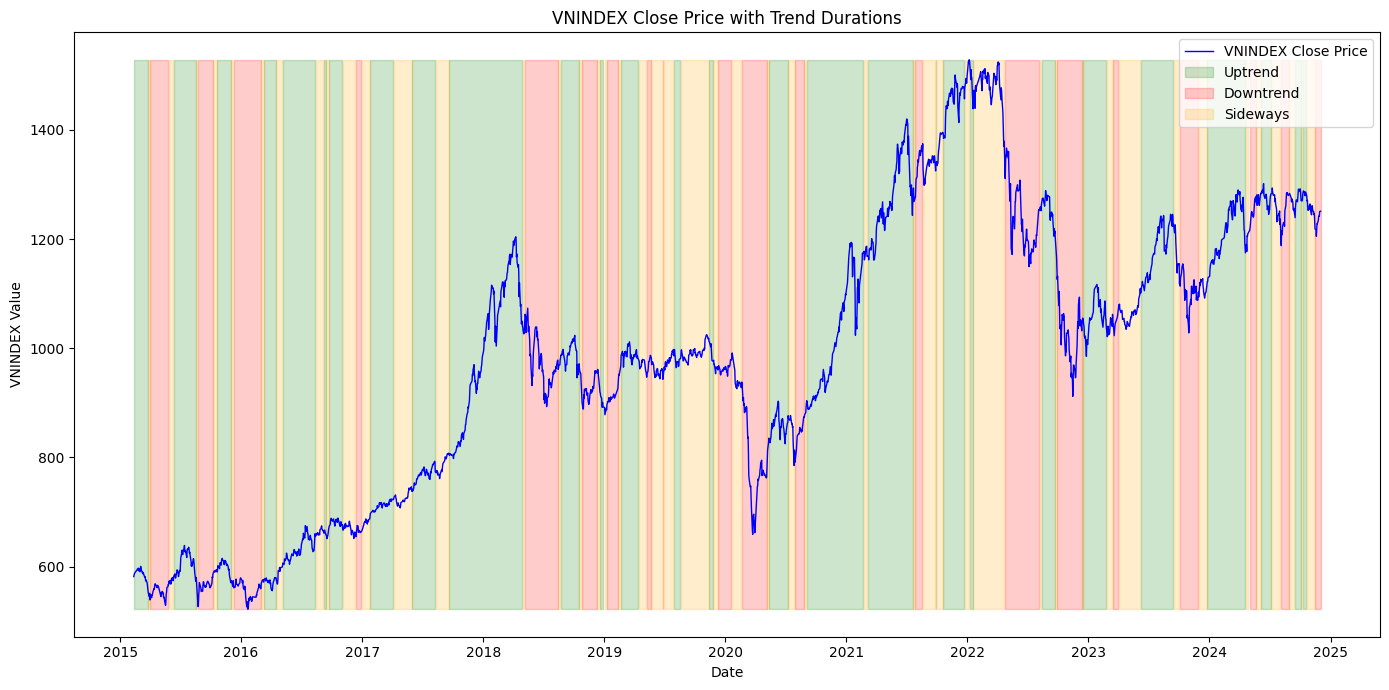

In [ ]:
# Vẽ biểu đồ giá Close với các vùng xu hướng
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], color='blue', label='VNINDEX Close Price', linewidth=1)

# Vùng màu xu hướng
colors = {'Uptrend': 'green', 'Downtrend': 'red', 'Sideways': 'orange'}
for trend in ['Uptrend', 'Downtrend', 'Sideways']:
    plt.fill_between(df.index, df['close'].min(), df['close'].max(),
                     where=(df['Trend'] == trend), color=colors[trend], alpha=0.2, label=trend)

# Tùy chỉnh đồ thị
plt.title("VNINDEX Close Price with Trend Durations")
plt.xlabel("Date")
plt.ylabel("VNINDEX Value")
plt.legend()
plt.tight_layout()
plt.show()

'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


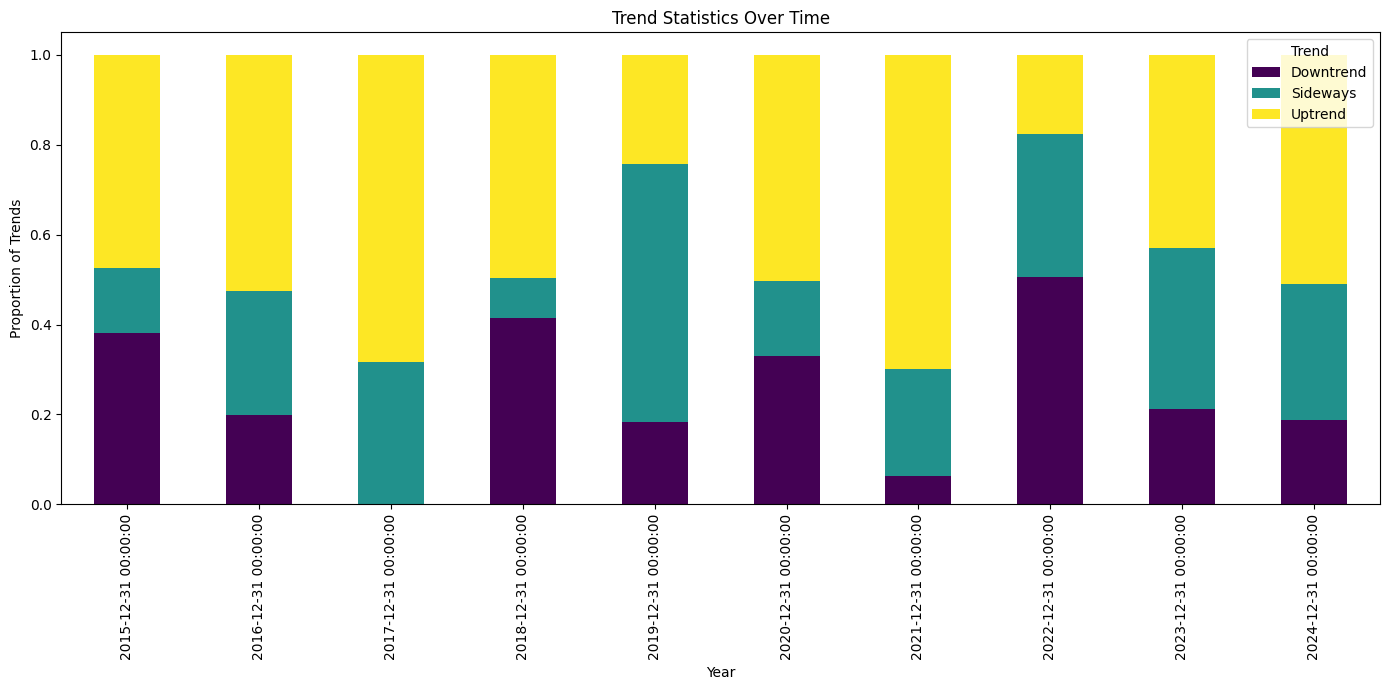

Trend,Downtrend,Sideways,Uptrend
time,,,
2015-12-31,0.380090,0.144796,0.475113
2016-12-31,0.199203,0.274900,0.525896
2017-12-31,0.000000,0.316000,0.684000
2018-12-31,0.415323,0.088710,0.495968
2019-12-31,0.184000,0.572000,0.244000
2020-12-31,0.329365,0.166667,0.503968
2021-12-31,0.064000,0.236000,0.700000
2022-12-31,0.506024,0.317269,0.176707
2023-12-31,0.212851,0.357430,0.429719


In [ ]:
# Calculate statistics for trends over time
trend_stats_over_time = df.resample('Y')['Trend'].value_counts(normalize=True).unstack(fill_value=0)

# Plot trend statistics over time
plt.figure(figsize=(14, 7))
trend_stats_over_time.plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())
plt.title('Trend Statistics Over Time')
plt.ylabel('Proportion of Trends')
plt.xlabel('Year')
plt.legend(title='Trend')
plt.tight_layout()
plt.show()

trend_stats_over_time

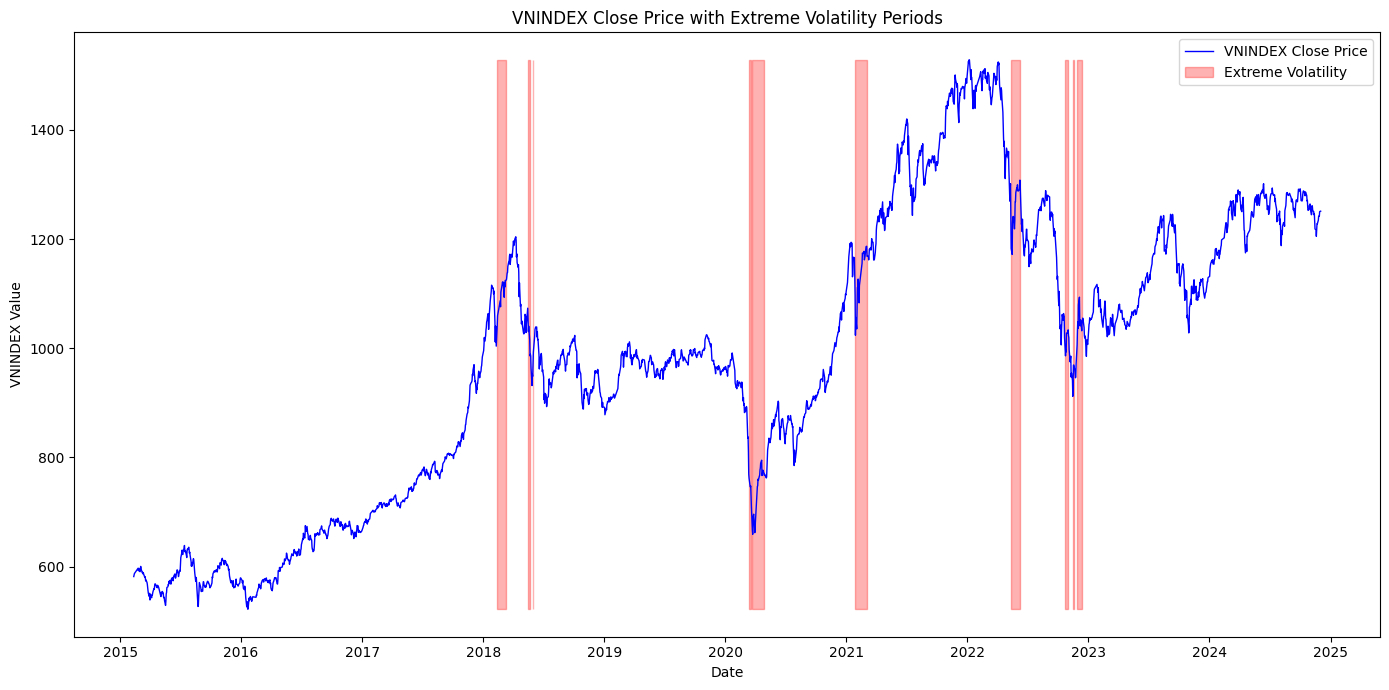

In [ ]:
# Calculate log returns for volatility measurement
df['Log_Return'] = np.log(df['close'] / df['close'].shift(1))

# Calculate rolling volatility (standard deviation of log returns) using a 20-day window
df['Volatility'] = df['Log_Return'].rolling(window=20).std()

# Define extreme volatility threshold (e.g., 2 times the mean volatility)
volatility_threshold = 2 * df['Volatility'].mean()

# Identify extreme volatility periods
df['Extreme_Volatility'] = df['Volatility'] > volatility_threshold

# Plot VNINDEX Close Price with Extreme Volatility Periods Highlighted
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], color='blue', label='VNINDEX Close Price', linewidth=1)

# Highlight extreme volatility periods
plt.fill_between(df.index, df['close'].min(), df['close'].max(),
                 where=df['Extreme_Volatility'], color='red', alpha=0.3, label='Extreme Volatility')

# Formatting
plt.title("VNINDEX Close Price with Extreme Volatility Periods")
plt.xlabel("Date")
plt.ylabel("VNINDEX Value")
plt.legend()
plt.tight_layout()
plt.show()

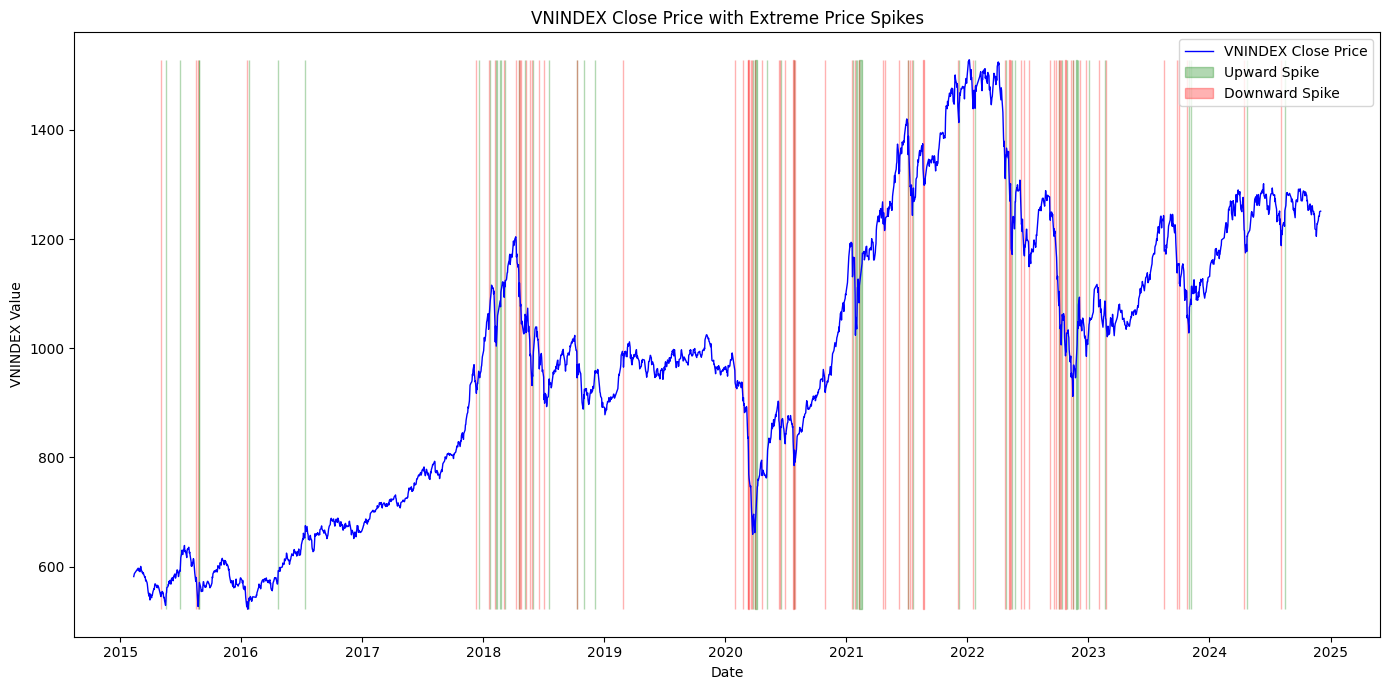

In [ ]:
# Calculate daily returns
df['Daily_Return'] = df['close'].pct_change()

# Define extreme price spikes threshold (2 times the standard deviation of returns)
spike_threshold = 2 * df['Daily_Return'].std()

# Identify extreme upward and downward spikes
df['Upward_Spike'] = df['Daily_Return'] > spike_threshold
df['Downward_Spike'] = df['Daily_Return'] < -spike_threshold

# Plot VNINDEX Close Price with Extreme Price Spikes Highlighted
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], color='blue', label='VNINDEX Close Price', linewidth=1)

# Highlight upward spikes
plt.fill_between(df.index, df['close'].min(), df['close'].max(),
                 where=df['Upward_Spike'], color='green', alpha=0.3, label='Upward Spike')

# Highlight downward spikes
plt.fill_between(df.index, df['close'].min(), df['close'].max(),
                 where=df['Downward_Spike'], color='red', alpha=0.3, label='Downward Spike')

# Formatting
plt.title("VNINDEX Close Price with Extreme Price Spikes")
plt.xlabel("Date")
plt.ylabel("VNINDEX Value")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df.dropna(inplace=True)
df

,open,high,low,close,volume,MA_20,MA_50,MA_Diff,Trend,Log_Return,Volatility,Extreme_Volatility,Daily_Return,Upward_Spike,Downward_Spike
time,,,,,,,,,,,,,,,
2015-03-19,579.39,580.32,573.52,573.74,84526970,589.1890,577.0812,12.1078,Uptrend,-0.008573,0.007231,False,-0.008537,False,False
2015-03-20,572.57,577.56,571.92,575.44,150546960,588.7275,577.8386,10.8889,Uptrend,0.002959,0.007161,False,0.002963,False,False
2015-03-23,576.64,579.39,570.44,570.89,97498172,587.9100,578.3438,9.5662,Uptrend,-0.007938,0.007222,False,-0.007907,False,False
2015-03-24,569.33,569.91,562.07,567.43,90781673,586.4340,578.8034,7.6306,Uptrend,-0.006079,0.005939,False,-0.006061,False,False
2015-03-25,567.62,568.40,559.87,560.93,87606340,584.8475,579.0288,5.8187,Uptrend,-0.011521,0.006190,False,-0.011455,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-26,1234.70,1246.83,1234.70,1242.13,575094638,1240.2885,1262.2130,21.9245,Downtrend,0.006000,0.007055,False,0.006018,False,False
2024-11-27,1242.13,1245.34,1239.23,1241.97,428809652,1239.4555,1261.7544,22.2989,Downtrend,-0.000129,0.007044,False,-0.000129,False,False
2024-11-28,1246.37,1250.46,1240.91,1242.11,477493690,1238.3370,1261.1712,22.8342,Downtrend,0.000113,0.006937,False,0.000113,False,False


In [ ]:
# Feature and target selection
df_ml = df.dropna().copy()
X = df_ml[['open', 'high', 'low', 'close', 'volume', 'MA_20', 'MA_50', 'Volatility', 'Log_Return', 'Daily_Return']]
y = df_ml['Trend']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [ ]:
# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Feature importance
feature_importances = pd.DataFrame({
    'RandomForest': rf_model.feature_importances_,
    'XGBoost': xgb_model.feature_importances_
}, index=X.columns)

[14:22:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



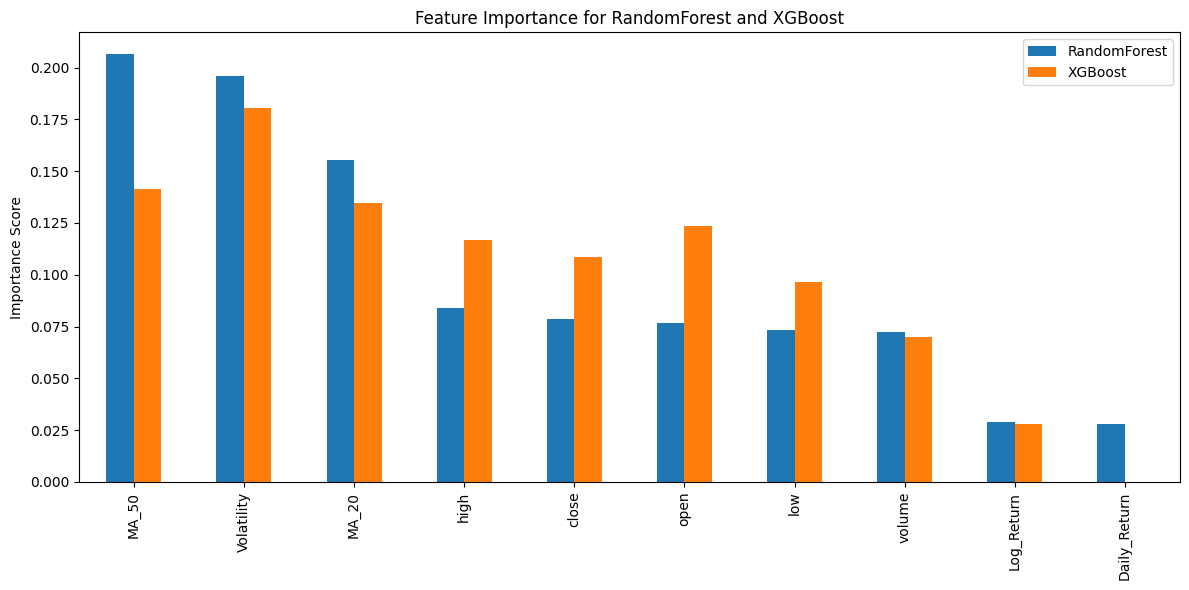

In [ ]:
# Plot feature importance
feature_importances = feature_importances.sort_values(by='RandomForest', ascending=False)

plt.figure(figsize=(12, 6))
feature_importances.plot(kind='bar', title="Feature Importance for RandomForest and XGBoost", ax=plt.gca())
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [ ]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True)

In [ ]:
def calculate_results(y_true, y_pred):
    '''
    Calculate accuracy, precision, recall, f1 score for a model
    '''
    model_accuracy = accuracy_score(y_true, y_pred) * 100  # Scale to 1-100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }

    return model_results

In [ ]:
def kfold_evaluation(model, X, y, kfold):
    '''
    1. Train ML model using KFold with Regularization, Hyperparameter Tuning, and Ensemble Methods.
    2. Return metrics for each KFold and aggregate results.
    3. Retrain the final model on the entire dataset after K-fold.
    '''
    fold_results = []  # Metrics for each fold
    fold_result_each_kfold = []  # Detailed metrics for training and validation
    best_model = None
    best_metric = -np.inf  # Track the best F1 score across folds

    # Define the parameter grid for hyperparameter tuning
    param_grid = {
        'n_estimators': [50, 100, 200],                # Number of trees
        'max_depth': [4, 6, 8],                   # Depth of each tree
        'min_samples_split': [15, 25, 35],            # Min samples to split a node
        'min_samples_leaf': [10, 15, 20],              # Min samples per leaf
        'max_features': ['sqrt', 'log2', None],       # Feature selection strategies
        'max_samples': [0.6, 0.8, 1.0]                # Fraction of data for bootstrap
    }

    # Step 1: K-Fold Cross-Validation
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y), start=1):
        print(f"\n--- Processing Fold {fold} ---")

        # Split data into training and validation sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Hyperparameter Tuning with GridSearchCV
        print("  Optimizing hyperparameters using GridSearchCV...")
        grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        fold_best_model = grid_search.best_estimator_

        print(f"  Best parameters for Fold {fold}: {grid_search.best_params_}")

        # Train the model with the best parameters
        fold_best_model.fit(X_train, y_train)

        # Predict on both training and validation sets
        train_predictions = fold_best_model.predict(X_train)
        val_predictions = fold_best_model.predict(X_val)

        # Calculate metrics for both sets
        train_metrics = calculate_results(y_train, train_predictions)
        val_metrics = calculate_results(y_val, val_predictions)

        print(f"  Metrics on Fold {fold} - Validation: {val_metrics}")

        # Update the best model if the current fold performs better
        current_metric = val_metrics["f1"]
        if current_metric > best_metric:
            best_metric = current_metric
            best_model = deepcopy(fold_best_model)
            print(f"  New best model found on Fold {fold} with F1: {best_metric}")

        # Append results
        fold_result = {
            'fold': fold,
            'train_metrics': train_metrics,
            'validation_metrics': val_metrics
        }
        fold_results.append(val_metrics)
        fold_result_each_kfold.append(fold_result)

    # Compute average metrics across all folds
    model_results = {
        "accuracy": np.mean([result["accuracy"] for result in fold_results]),
        "precision": np.mean([result["precision"] for result in fold_results]),
        "recall": np.mean([result["recall"] for result in fold_results]),
        "f1": np.mean([result["f1"] for result in fold_results])
    }

    print("\n--- Average Metrics Across Folds ---")
    for metric, value in model_results.items():
        print(f"  {metric.capitalize()}: {value:.4f}")

    # Display classification report for the final fold
    print("\n--- Classification Report for Last Fold ---")
    print(classification_report(y_val, val_predictions))

    # Step 2: Retrain on Entire Dataset
    print("\n--- Retraining Final Model on Entire Dataset ---")
    final_model = deepcopy(best_model)  # Clone the best model
    final_model.fit(X, y)  # Train on all data

    print("Retraining completed. Final model is ready for deployment.")

    return final_model, fold_result_each_kfold, model_results

In [ ]:
def format_metrics_compact(metrics):
    '''
    Helper function to format metrics compactly
    '''
    return ", ".join([f"{key.capitalize()}: {value:.2f}" for key, value in metrics.items()])

def display_all_folds_results(model_name, model_results):
    '''
    Print average metrics of validation data on all KFolds
    '''
    print(f"Average {model_name} Performance Metrics Across All Folds (on validation data):")
    print(f"- Accuracy: {model_results['accuracy']:.2f}%")
    print(f"- Precision: {model_results['precision']:.4f}")
    print(f"- Recall: {model_results['recall']:.4f}")
    print(f"- F1 Score: {model_results['f1']:.4f}")

In [ ]:
def display_each_fold_result(model_name, fold_results):
    '''
    Print metrics of training and validation data on each KFold and plot the accuracy graph using Seaborn.
    '''
    sns.set(style="whitegrid", palette="muted")
    colors = ["#3498db", "#e74c3c"]  # Blue for Training, Red for Validation

    print(f"{model_name} Performance Metrics Across Each Fold (on training and validation data):")
    print()
    print(f"{'Fold':<5} | {'Training Metrics':<70} | {'Validation Metrics':<70}")
    print("-" * 150)

    train_accuracies = []
    val_accuracies = []
    folds = []

    for result in fold_results:
        train_metrics_formatted = format_metrics_compact(result['train_metrics'])
        val_metrics_formatted = format_metrics_compact(result['validation_metrics'])
        print(f"{result['fold']:<5} | {train_metrics_formatted:<70} | {val_metrics_formatted:<70}")

        # Append data for graph
        folds.append(result['fold'])
        train_accuracies.append(result['train_metrics']['accuracy'])
        val_accuracies.append(result['validation_metrics']['accuracy'])

    # Plotting the accuracies
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(x=folds, y=train_accuracies, label='Training Accuracy', marker='o', color=colors[0])
    sns.lineplot(x=folds, y=val_accuracies, label='Validation Accuracy', marker='o', color=colors[1])
    ax.set_facecolor('#f8f9fa')

    label_offset = 0.25
    for i, (tr_acc, val_acc) in enumerate(zip(train_accuracies, val_accuracies)):
        ax.text(folds[i], tr_acc + label_offset, f"{tr_acc:.2f}%", ha='center', va='bottom')
        ax.text(folds[i], val_acc + label_offset, f"{val_acc:.2f}%", ha='center', va='bottom')

    plt.title(f"{model_name} model: Training vs Validation Accuracy per Fold")
    plt.xlabel('Fold')
    plt.ylabel('Accuracy (%)')
    plt.xticks(folds)
    plt.legend()
    ax.margins(y=0.2)  # Add 10% padding to the top and bottom
    fig.tight_layout()
    plt.show()

In [ ]:
attributes = ['MA_50', 'MA_20', 'Volatility']
X = df_ml[attributes]
y = df_ml['Trend']
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [ ]:
rf_model = RandomForestClassifier()

rf_model, rf_each_fold_results, rf_results = kfold_evaluation(rf_model, X_train.values, y_train, skf)


--- Processing Fold 1 ---
  Optimizing hyperparameters using GridSearchCV...
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
  Best parameters for Fold 1: {'max_depth': 8, 'max_features': None, 'max_samples': 1.0, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 100}
  Metrics on Fold 1 - Validation: {'accuracy': 82.77634961439588, 'precision': 0.832076989730909, 'recall': 0.8277634961439588, 'f1': 0.8219487120578273}
  New best model found on Fold 1 with F1: 0.8219487120578273

--- Processing Fold 2 ---
  Optimizing hyperparameters using GridSearchCV...
Fitting 3 folds for each of 729 candidates, totalling 2187 fits
  Best parameters for Fold 2: {'max_depth': 8, 'max_features': None, 'max_samples': 1.0, 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 50}
  Metrics on Fold 2 - Validation: {'accuracy': 78.40616966580977, 'precision': 0.7858928662545357, 'recall': 0.7840616966580977, 'f1': 0.7782718274740353}

--- Processing Fold 3 ---
  

In [ ]:
display_all_folds_results("Random Forest", rf_results)

Average Random Forest Performance Metrics Across All Folds (on validation data):
- Accuracy: 81.42%
- Precision: 0.8157
- Recall: 0.8142
- F1 Score: 0.8091


Random Forest Performance Metrics Across Each Fold (on training and validation data):

Fold  | Training Metrics                                                       | Validation Metrics                                                    
------------------------------------------------------------------------------------------------------------------------------------------------------
1     | Accuracy: 84.81, Precision: 0.85, Recall: 0.85, F1: 0.84               | Accuracy: 82.78, Precision: 0.83, Recall: 0.83, F1: 0.82              
2     | Accuracy: 85.59, Precision: 0.86, Recall: 0.86, F1: 0.85               | Accuracy: 78.41, Precision: 0.79, Recall: 0.78, F1: 0.78              
3     | Accuracy: 83.59, Precision: 0.84, Recall: 0.84, F1: 0.83               | Accuracy: 80.21, Precision: 0.81, Recall: 0.80, F1: 0.79              
4     | Accuracy: 85.08, Precision: 0.85, Recall: 0.85, F1: 0.85               | Accuracy: 85.82, Precision: 0.86, Recall: 0.86, F1: 0.86              
5 

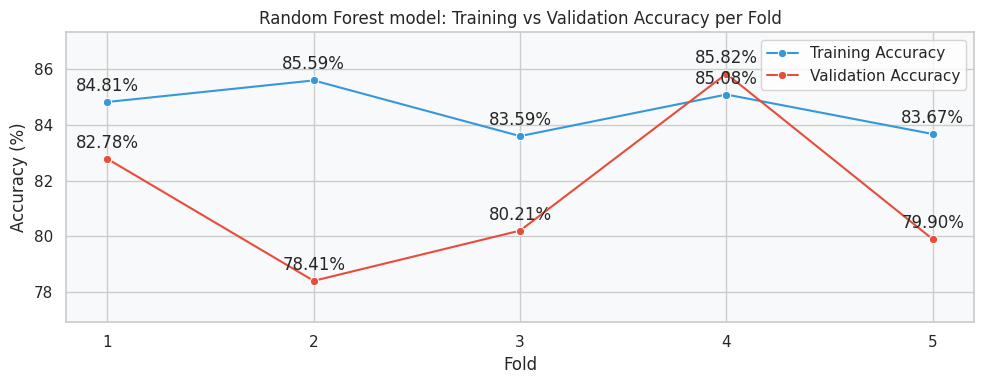

In [ ]:
display_each_fold_result("Random Forest", rf_each_fold_results)

In [ ]:
def predict_trend_over_period(model, X_test, y_test, label_encoder, window_size=5):
    """
    Dự đoán xu hướng tổng thể trên các khoảng thời gian trong tập test.

    Parameters:
    - model: Mô hình đã huấn luyện.
    - X_test: Tập dữ liệu test (features).
    - y_test: Xu hướng thực tế (encoded).
    - label_encoder: Bộ mã hóa nhãn xu hướng.
    - window_size: Kích thước khoảng thời gian (số ngày).

    Returns:
    - DataFrame chứa xu hướng thực tế, xu hướng dự đoán và tỉ lệ dự đoán đúng theo từng khoảng thời gian.
    """
    n_samples = len(X_test)
    results = []

    for start_idx in range(0, n_samples, window_size):
        end_idx = min(start_idx + window_size, n_samples)

        # Lấy dữ liệu trong khoảng thời gian
        X_window = X_test[start_idx:end_idx]
        y_window = y_test[start_idx:end_idx]

        # Dự đoán xu hướng cho khoảng thời gian
        y_pred_window = model.predict(X_window)
        y_pred_majority = np.bincount(y_pred_window).argmax()  # Xu hướng chiếm ưu thế

        # Thực tế xu hướng trong khoảng thời gian
        y_actual_majority = np.bincount(y_window).argmax()

        # Chuyển nhãn về dạng chuỗi
        y_pred_label = label_encoder.inverse_transform([y_pred_majority])[0]
        y_actual_label = label_encoder.inverse_transform([y_actual_majority])[0]

        # Tính tỉ lệ dự đoán đúng trong khoảng thời gian
        correct_predictions = np.sum(y_window == y_pred_window)
        accuracy_percent = (correct_predictions / len(y_window)) * 100

        # Lưu kết quả
        results.append({
            "Start_Index": start_idx,
            "End_Index": end_idx - 1,
            "Actual Trend": y_actual_label,
            "Predicted Trend": y_pred_label,
            "Correct": y_pred_label == y_actual_label,
            "Accuracy (%)": round(accuracy_percent, 2)
        })

    # Tạo DataFrame kết quả
    results_df = pd.DataFrame(results)
    return results_df

In [ ]:
results_over_period = predict_trend_over_period(rf_model, X_test, y_test, label_encoder, window_size=20)
results_over_period

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but Ran

,Start_Index,End_Index,Actual Trend,Predicted Trend,Correct,Accuracy (%)
0,0,19,Uptrend,Uptrend,True,95.00
1,20,39,Uptrend,Uptrend,True,85.00
2,40,59,Uptrend,Uptrend,True,95.00
3,60,79,Uptrend,Uptrend,True,80.00
4,80,99,Uptrend,Uptrend,True,80.00
5,100,119,Sideways,Uptrend,False,90.00
6,120,139,Uptrend,Uptrend,True,90.00
7,140,159,Uptrend,Uptrend,True,85.00
8,160,179,Uptrend,Uptrend,True,90.00
9,180,199,Uptrend,Uptrend,True,75.00


In [ ]:
def predict_trend_random_period(model, X_test, y_test, label_encoder, window_size=5, num_periods=5):
    """
    Dự đoán xu hướng tổng thể trên các khoảng thời gian ngẫu nhiên trong tập test và trực quan hóa kết quả.

    Parameters:
    - model: Mô hình đã huấn luyện.
    - X_test: Tập dữ liệu test (features).
    - y_test: Xu hướng thực tế (encoded).
    - label_encoder: Bộ mã hóa nhãn xu hướng.
    - window_size: Kích thước khoảng thời gian (số ngày).
    - num_periods: Số lượng khoảng thời gian ngẫu nhiên cần lấy.

    Returns:
    - DataFrame chứa xu hướng thực tế, xu hướng dự đoán và tỉ lệ dự đoán đúng cho các khoảng thời gian ngẫu nhiên.
    - Hiển thị trực quan hóa và đánh giá hiệu suất.
    """
    n_samples = len(X_test)
    results = []
    y_actual_all, y_pred_all = [], []

    # Sinh ngẫu nhiên các chỉ số bắt đầu cho khoảng thời gian
    random_starts = random.sample(range(0, n_samples - window_size), num_periods)

    for start_idx in random_starts:
        end_idx = start_idx + window_size

        # Lấy dữ liệu trong khoảng thời gian
        X_window = X_test[start_idx:end_idx]
        y_window = y_test[start_idx:end_idx]

        # Dự đoán xu hướng cho khoảng thời gian
        y_pred_window = model.predict(X_window)
        y_pred_majority = np.bincount(y_pred_window).argmax()  # Xu hướng chiếm ưu thế

        # Thực tế xu hướng trong khoảng thời gian
        y_actual_majority = np.bincount(y_window).argmax()

        # Chuyển nhãn về dạng chuỗi
        y_pred_label = label_encoder.inverse_transform([y_pred_majority])[0]
        y_actual_label = label_encoder.inverse_transform([y_actual_majority])[0]

        # Tính tỉ lệ dự đoán đúng trong khoảng thời gian
        correct_predictions = np.sum(y_window == y_pred_window)
        accuracy_percent = (correct_predictions / len(y_window)) * 100

        # Lưu kết quả
        results.append({
            "Start_Index": start_idx,
            "End_Index": end_idx - 1,
            "Actual Trend": y_actual_label,
            "Predicted Trend": y_pred_label,
            "Correct": y_pred_label == y_actual_label,
            "Accuracy (%)": round(accuracy_percent, 2)
        })

        # Lưu tất cả nhãn dự đoán và thực tế để đánh giá tổng thể
        y_actual_all.extend(y_window)
        y_pred_all.extend(y_pred_window)

    # Tạo DataFrame kết quả
    results_df = pd.DataFrame(results)

    # Visualization - Confusion Matrix
    conf_matrix = confusion_matrix(y_actual_all, y_pred_all)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix for Random Period Predictions")
    plt.show()

    # Visualization - Accuracy of Each Period
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(results_df)), results_df['Accuracy (%)'], color='skyblue')
    plt.title("Prediction Accuracy for Each Random Period")
    plt.xlabel("Random Period Index")
    plt.ylabel("Accuracy (%)")
    plt.xticks(range(len(results_df)), [f"Period {i+1}" for i in range(len(results_df))], rotation=45)
    plt.tight_layout()
    plt.show()

    return results_df

X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but RandomForestClassifier was fitted without feature names


<Figure size 800x600 with 0 Axes>

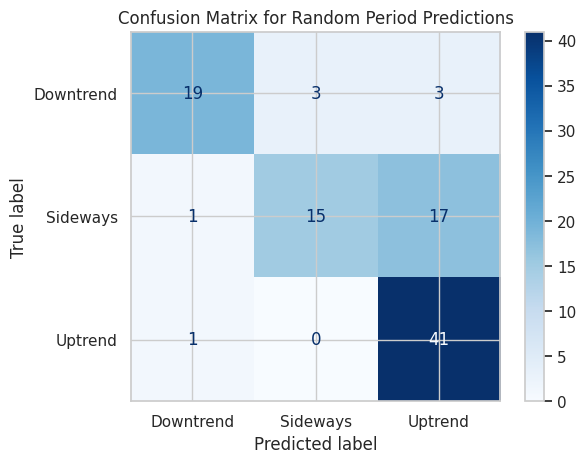

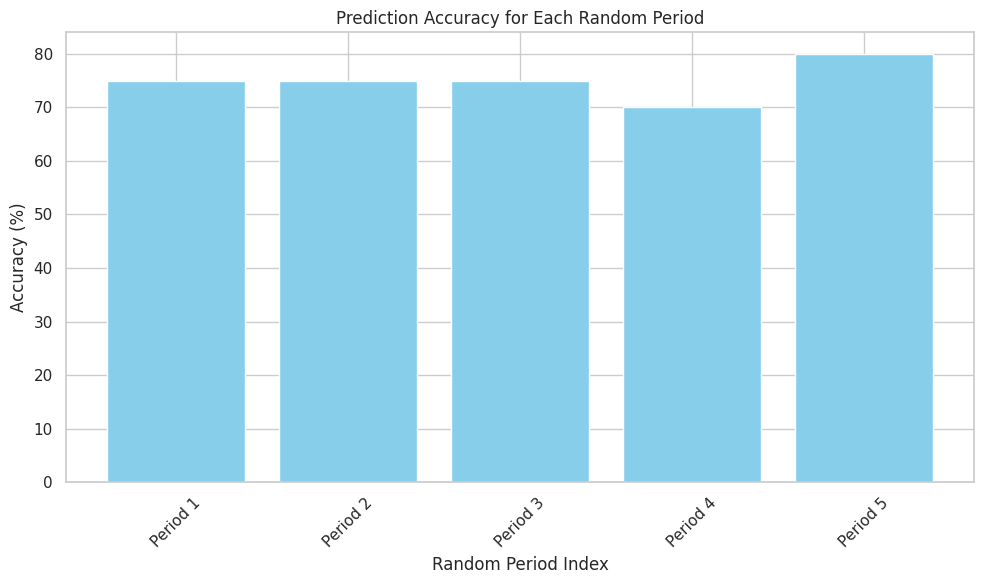

,Start_Index,End_Index,Actual Trend,Predicted Trend,Correct,Accuracy (%)
0,448,467,Sideways,Uptrend,False,75.0
1,323,342,Uptrend,Uptrend,True,75.0
2,55,74,Uptrend,Uptrend,True,75.0
3,290,309,Sideways,Uptrend,False,70.0
4,143,162,Uptrend,Uptrend,True,80.0


In [ ]:
results_random_period = predict_trend_random_period(rf_model, X_test, y_test, label_encoder, window_size=20, num_periods=5)
results_random_period